# Demonstrate predictions using Diabetes model based on CMS Prevalence of Diabetes and AHRQ SDOH


__[GitHub: SocialHealthAI/SDOH-Models](https://github.com/SocialHealthAI/SDOH-Models)__

## Overview
Using the Random Forest model developed in csm_ahrq_diabetes, demostrate trends and predictions for select counties.  Select the state and counties in Set up Environment below. 

# Set up Environment

In [1]:
%run ../../environment/env1.ipynb

var_counties = ['Grant', 'Kenton', 'Campbell', 'Pendleton']
var_state = 'Kentucky'
#var_counties = ['Hamilton', 'Clermont', 'Butler', 'Brown']
#var_state = 'Ohio'

# Extract, transform and load data

## CMS Diabetes Prevalence
Call CMS Chronic Data notebook using year and disease parameters.

In [2]:
parm_CMSChronic_disease = 'Diabetes'
parm_CMSChronic_years = ['2015', '2016', '2017', '2018']
%run ../../etl/dataCMSChronic.ipynb
dfCMSChronicPrevalence = out_CMSChronic()

## AHRQ Social Determinants of Health Data
Call AHRQ SDOH Data notebook using year parameter.

In [3]:
parm_AHRQCountySDOH_years = ['2015', '2016', '2017', '2018', '2019']
# currently not including NOAAC - temperature by month
parm_AHRQCountySDOH_surveys = ["ACS", "AHA", "AMFAR", "CCBP", "CDCSVI", "CEN", "CRDC", "EPAA", "FARA", "FEA", "HHC", "HIFLD", "HRSA", "MHSVI", "MP", "NCHS", "NEPHTN", "NHC", "NOAAS", "POS", "SAHIE", "SAIPE", "SEDA"]
parm_AHRQCountySDOH_questions = ["CDCW_INJURY_DTH_RATE", "CDCW_TRANSPORT_DTH_RATE", "CDCW_SELFHARM_DTH_RATE", "CDCW_ASSAULT_DTH_RATE", "CHR_TOT_MENTAL_PROV", "CHR_MENTAL_PROV_RATE", "CHR_SEGREG_BLACK", "CHR_PCT_ALCOHOL_DRIV_DEATH", "CHR_PCT_EXCESS_DRINK", "CHR_PCT_FOOD", "CHR_SEGREG_BLACK", "CHR_SEGREG_NON_WHITE"]
%run ../../etl/dataAHRQCountySDOH.ipynb
dfAHRQCountySDOH = out_AHRQCountySDOH()

## Merge Data

In [4]:
dfMerged = pd.merge(dfAHRQCountySDOH[dfAHRQCountySDOH['YEAR'] < 2019], dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])

X = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y = dfMerged["DIABETES"]

# Fit Random Forest model
Use all features. Training and test data sets are not necessary as random forest uses 2/3 of the data to grow each tree and the remaining 1/3 is used to calculate out-of-bag error to compute the model performance.

In [5]:
# define the model
rf = RandomForestRegressor(n_estimators= 20, random_state=5)
# fit the random forest model
rf.fit(X, Y)

RandomForestRegressor(n_estimators=20, random_state=5)

R2 Score:  0.983371150870263


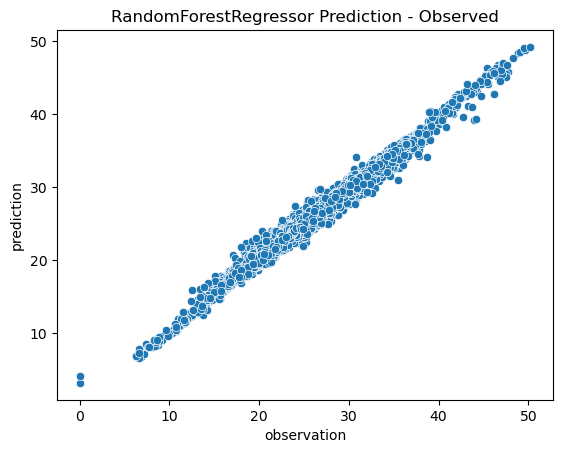

In [6]:
Y_pred = rf.predict(X)
print("R2 Score: ", r2_score(Y,Y_pred))

Y_list = Y.tolist()
scatterplot(x=Y_list, y=Y_pred)
plt.title('RandomForestRegressor Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Predictions for future year

### Create test set for future year

In [7]:
dfAHRQCountySDOHFuture = dfAHRQCountySDOH[dfAHRQCountySDOH['YEAR'] == 2019]
X_Future = dfAHRQCountySDOHFuture.drop(["STATE", "COUNTY", "YEAR"], axis = 1)
#X_testFutureSelected = X_testFuture[listSelectedFeatures]

### Predict

In [8]:
Y_pred_Future = rf.predict(X_Future)

### Set up dataframe for plot with diabetes prevalence and diabetes prediction

In [9]:
dfCMS = dfCMSChronicPrevalence[['YEAR', 'STATE', 'COUNTY', 'DIABETES']]
dfPred = pd.DataFrame(Y_pred_Future)
dfPred.rename(columns={0: 'DIABETES'}, inplace=True)
dfAHRQ = dfAHRQCountySDOHFuture[['YEAR', 'STATE', 'COUNTY']]
dfAHRQ = pd.concat([dfAHRQ, dfPred], axis=1)
dfCMSAHRQ = dfCMS.append(dfAHRQ, ignore_index=True)

### Plot diabetes by year by county

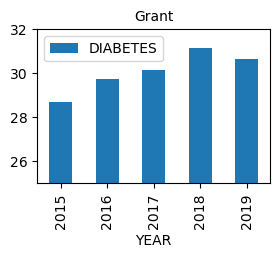

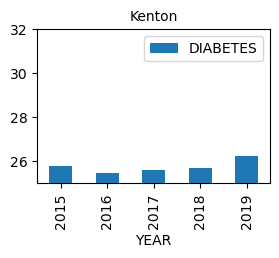

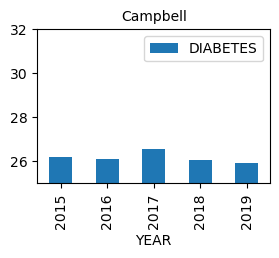

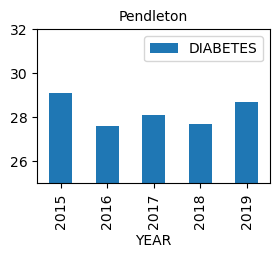

In [10]:
for county in var_counties:
    dfDisplay = dfCMSAHRQ[(dfCMSAHRQ.COUNTY == county) & (dfCMSAHRQ.STATE == var_state)]
    dfDisplay= dfDisplay.sort_values('YEAR',ascending=True)
    dfDisplay.plot(x="YEAR", y="DIABETES", kind="bar", figsize=(3,2))
    plt.title(county , fontsize=10)
    plt.ylim(25, 32)
    #plt.tight_layout()
    plt.show()